In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

print("Libraries imported.")

Libraries imported.


In [2]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
faces = lfw_dataset.data
n_samples, n_features = faces.shape
image_shape = lfw_dataset.images[0].shape
target_names = lfw_dataset.target_names
n_classes = target_names.shape[0]

print("LFW dataset loaded.")
print("Number of samples:", n_samples)
print("Number of features per sample:", n_features)
print("Image shape:", image_shape)
print("Number of classes:", n_classes)

# Center the data (important for PCA and standard POD equivalence)
faces_centered = faces - faces.mean(axis=0)

LFW dataset loaded.
Number of samples: 1288
Number of features per sample: 1850
Image shape: (50, 37)
Number of classes: 7


In [3]:
n_components_pca = 150 # Number of components to keep for PCA

pca = PCA(n_components=n_components_pca)
pca.fit(faces_centered) # Fit PCA on the centered data

faces_pca_reduced = pca.transform(faces_centered) # Reduce dimensionality using PCA
faces_pca_reconstructed = pca.inverse_transform(faces_pca_reduced) # Reconstruct using PCA

print("PCA implemented and data transformed/reconstructed.")
print("Explained variance ratio by PCA (first 5 components):", pca.explained_variance_ratio_[:5])

PCA implemented and data transformed/reconstructed.
Explained variance ratio by PCA (first 5 components): [0.20562977 0.13948898 0.06917711 0.05701404 0.04862096]


In [4]:
n_components_pod = 150 # Number of components to keep for POD

# POD is essentially SVD applied to the data matrix (when data is centered)
U, S, V = np.linalg.svd(faces_centered)

# Keep only the top 'n_components_pod' singular values and vectors
U_reduced = U[:, :n_components_pod]
S_reduced = np.diag(S[:n_components_pod])
V_reduced = V[:n_components_pod, :]

faces_pod_reconstructed = np.dot(U_reduced, np.dot(S_reduced, V_reduced)) # Reconstruct using POD

print("POD (via SVD) implemented and data reconstructed.")
print("Singular values (first 5):", S[:5])

POD (via SVD) implemented and data reconstructed.
Singular values (first 5): [104.06264   85.7081    60.357742  54.79524   50.6015  ]


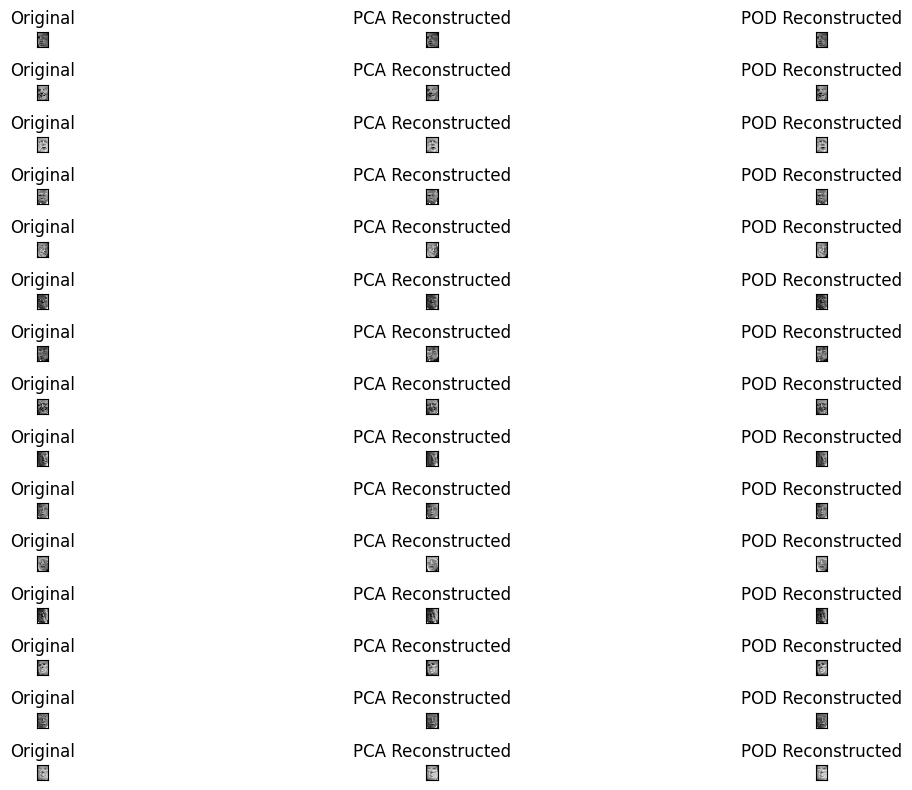

In [5]:
def plot_faces(original_faces, reconstructed_faces_pca, reconstructed_faces_pod, n_row=3, n_col=5):
    plt.figure(figsize=(15, 8))
    for i in range(n_row * n_col):
        plt.subplot(n_row * n_col, 3, 3*i + 1)
        plt.imshow(original_faces[i].reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.title('Original')

        plt.subplot(n_row * n_col, 3, 3*i + 2)
        plt.imshow(reconstructed_faces_pca[i].reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.title('PCA Reconstructed')

        plt.subplot(n_row * n_col, 3, 3*i + 3)
        plt.imshow(reconstructed_faces_pod[i].reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.title('POD Reconstructed')
    plt.tight_layout()
    plt.show()

plot_faces(faces_centered, faces_pca_reconstructed, faces_pod_reconstructed)

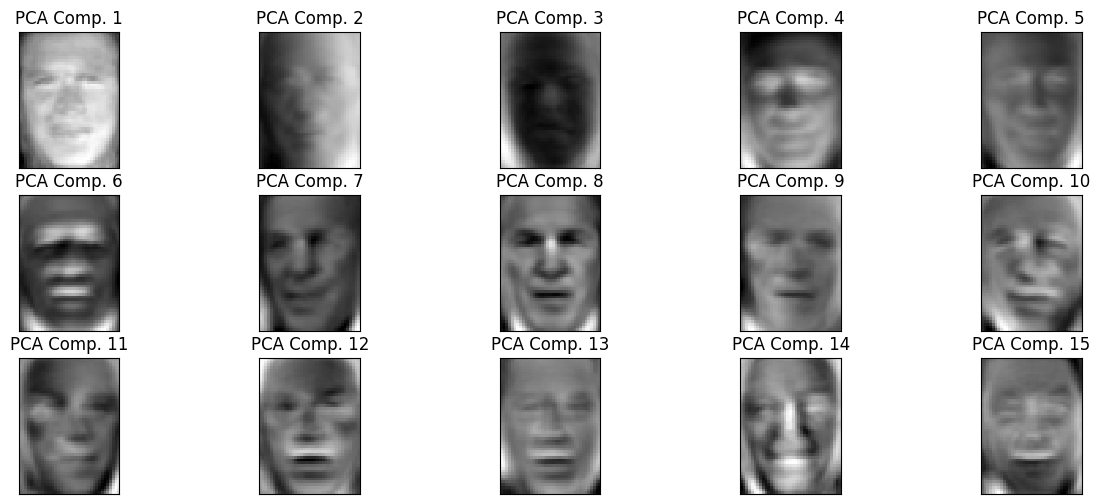

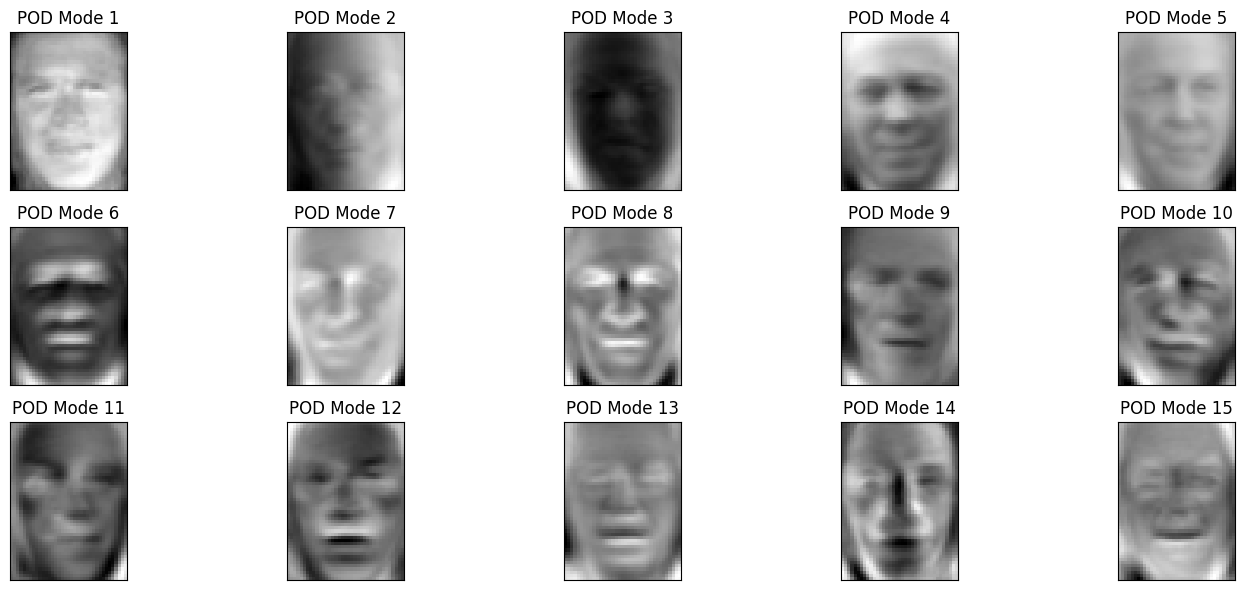

In [6]:
def plot_components(pca_components, pod_components, image_shape, n_row=3, n_col=5):
    plt.figure(figsize=(15, 6))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(pca_components[i].reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.title(f'PCA Comp. {i+1}')

    plt.figure(figsize=(15, 6))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(pod_components[i].reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.title(f'POD Mode {i+1}')
    plt.tight_layout()
    plt.show()

plot_components(pca.components_, V_reduced, image_shape) # pca.components_ are already V^T from SVD of centered data

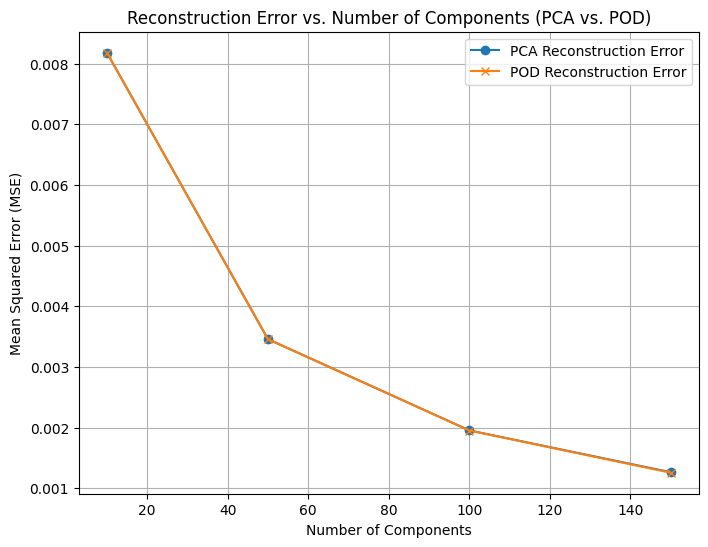

Reconstruction error (MSE) calculated and plotted.


In [7]:
n_components_range = [10, 50, 100, 150] # Range of components to test
mse_pca_list = []
mse_pod_list = []

for n_comps in n_components_range:
    # PCA
    pca_temp = PCA(n_components=n_comps)
    pca_temp.fit(faces_centered)
    faces_pca_reduced_temp = pca_temp.transform(faces_centered)
    faces_pca_reconstructed_temp = pca_temp.inverse_transform(faces_pca_reduced_temp)
    mse_pca = mean_squared_error(faces_centered, faces_pca_reconstructed_temp)
    mse_pca_list.append(mse_pca)

    # POD
    U_temp, S_temp, V_temp = np.linalg.svd(faces_centered)
    U_reduced_temp = U_temp[:, :n_comps]
    S_reduced_temp = np.diag(S_temp[:n_comps])
    V_reduced_temp = V_temp[:n_comps, :]
    faces_pod_reconstructed_temp = np.dot(U_reduced_temp, np.dot(S_reduced_temp, V_reduced_temp))
    mse_pod = mean_squared_error(faces_centered, faces_pod_reconstructed_temp)
    mse_pod_list.append(mse_pod)

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, mse_pca_list, marker='o', label='PCA Reconstruction Error')
plt.plot(n_components_range, mse_pod_list, marker='x', label='POD Reconstruction Error')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components (PCA vs. POD)')
plt.legend()
plt.grid(True)
plt.show()

print("Reconstruction error (MSE) calculated and plotted.")